# Figure FISH

In [201]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cut_tree
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
import pyvis as pv
from pyvis.network import Network
from joblib import Parallel, delayed

import utils as lu
reload(lu)

<module 'utils' from '/home/louiscam/projects/gpcr/code/processing_FISH/utils.py'>

In [2]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Directory of FISH data
dir_fish = '/home/louiscam/projects/gpcr/data/fish_data/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
saving_main_dir = '/home/louiscam/projects/gpcr/save/figures_main/'
saving_supp_dir = '/home/louiscam/projects/gpcr/save/figures_supplement/'

In [3]:
# Load gene to chromosome directory
with open(saving_dir+'gene2chrom.pkl', 'rb') as f:
    gene2chrom = pickle.load(f)
# Load gene to locus directory
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)

# Load FISH data

### Load genomic scale FISH data
Including for each locus whether the genes measured within it are actively transcribing and the distances from the locus to the nuclear lamina, the nearest nuclear speckle and the nearest nucleolus.

In [4]:
# Load data
merfish_data = pd.read_csv(dir_fish+'dna_merfish_data.tsv', sep='\t', header=0)

In [5]:
# Build dictionary from Ensembl gene name to HGNC
enst2hgnc_df = pd.read_csv(dir_genome+'ensemblGene2Name', sep='\t', header=0)
enst2hgnc_df.columns = ['ENST', 'HGNC']
enst2hgnc_df = enst2hgnc_df.set_index('ENST')
ensg2enst_df = pd.read_csv(dir_genome+'ensemblGene2Transcript2Protein', sep='\t', header=0)
ensg2enst_df.columns = ['ENSG', 'ENST', 'ENSP']
ensg2enst_df = ensg2enst_df[['ENSG', 'ENST']]
ensg2enst_df = ensg2enst_df.set_index('ENST')
ensg2hgnc_df = ensg2enst_df.join(enst2hgnc_df, how='outer').reset_index()
ensg2hgnc_df = ensg2hgnc_df[['ENSG', 'HGNC']].drop_duplicates(['ENSG', 'HGNC'])
ensg2hgnc_df['HGNC'] = ensg2hgnc_df['HGNC'].str.upper()
ensg2hgnc_df = ensg2hgnc_df.reset_index()[['ENSG', 'HGNC']]
ensg2hgnc = {ensg2hgnc_df.loc[i,'ENSG']: ensg2hgnc_df.loc[i,'HGNC'] for i in range(len(ensg2hgnc_df))}

In [6]:
# Add gene information to MERFISH data
merfish_data['gene names'] = merfish_data['gene names'].astype(str)
merfish_data['gene names'] = merfish_data['gene names'].apply(lambda x: x.split(',') if x!='nan' else [])
merfish_data['gene_hgnc'] = merfish_data['gene names'].apply(lambda x: [ensg2hgnc[g] if (g in ensg2hgnc.keys()) 
                                                                    else 'unknown' for g in x] if len(x)>0 else [])
merfish_data['n_genes'] = merfish_data['gene_hgnc'].apply(lambda x: len(x))
merfish_data['transciption'] = merfish_data['transciption'].astype(str)
merfish_data['transciption'] = merfish_data['transciption'].apply(lambda x: x.split(',') if x!='nan' else [])
merfish_data['chrom'] = merfish_data['genomic coordinate'].str.split(':', expand=True)[0]

In [7]:
# Reduce data (drop NAs, chrX and gene-less loci)
merfish_data = merfish_data.dropna(how='any')
merfish_data = merfish_data[merfish_data['chrom']!='chrX']
merfish_data = merfish_data[['cell number',
                             'chrom',
                             'homolog number',
                             'genomic coordinate',
                             'gene_hgnc',
                             'transciption',
                             'x(nm)', 'y(nm)', 'z(nm)']]
merfish_data.columns = [ 'cell_ID',
                         'chrom',
                         'homolog',
                         'probe_locus',
                         'gene_ID',
                         'transcription',
                         'x(nm)', 'y(nm)', 'z(nm)']

In [8]:
# Print basic statistics
print(f'Total number of cells = {len(np.unique(merfish_data["cell_ID"].values))}')
print(f'Total number of loci = {len(np.unique(merfish_data["probe_locus"].values))}')

Total number of cells = 3533
Total number of loci = 990


# Load genes of interest

In [9]:
# Genes that we want to validate
# g1 = np.array(['SHARPIN', 'HRAS', 'SLC16A3', 'CD151', 'PLEC', 'UBE2I', 
#                'CFL1', 'PIP5K1C', 'PKD1', 'SHC1', 'TESK1', 'TLN1'])
g1 = np.array(['SHARPIN', 'HRAS', 'SLC16A3', 'CD151', 'PLEC', 'UBE2I', 
               'CFL1', 'PIP5K1C', 'PKD1', 'CAPN1', 'MAPK8IP3', 'PIAS4', 'STAT3'])
# Negative controls in GM12878
with open(saving_dir+'validation_genes_GM12878.pkl', 'rb') as f:
    g2 = pickle.load(f)
# Load all adhesome genes
with open(saving_dir+'all_adhesome_genes.pkl', 'rb') as f:
    all_adhesome_genes = pickle.load(f)
# Load active adhesome genes
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
# Combined genes
combined_adhesome_genes = np.unique(np.concatenate([g1, g2, all_adhesome_genes]))

In [10]:
# Sample random non-adhesome active genes
with open(saving_dir+'all_active_genes.pkl', 'rb') as f:
    all_active_genes = pickle.load(f)
with open(saving_dir+'all_inactive_genes.pkl', 'rb') as f:
    all_inactive_genes = pickle.load(f)
np.random.seed(13)
active_gene_pool = np.array(list(set(all_active_genes)-set(active_adhesome_genes)))
random_active_genes = active_gene_pool

In [11]:
# Genes for downstream analysis
selected_genes = np.concatenate([active_adhesome_genes, random_active_genes])
print(f'Number of selected genes = {len(selected_genes)}')

Number of selected genes = 22595


In [12]:
# Location of genes in hg38
df_loc = pd.read_csv(dir_genome+'chrom_hg38.loc', sep='\t', header=0)
df_loc = df_loc[df_loc['#chrom'].isin(['chr'+str(i) for i in range(1,23)])]
df_loc = df_loc[['#chrom', 'chromStart', 'chromEnd', 'geneName']]
df_loc.columns = ['chrom', 'start', 'end', 'geneName']
df_loc = df_loc.sort_values(['chrom','start','end'])
df_loc = df_loc.groupby(['chrom','geneName']).agg({'start':'min', 'end':'max'})
df_loc = df_loc.reset_index().sort_values(['chrom','start','end'])
df_loc_adhesome = df_loc[df_loc['geneName'].isin(selected_genes)]

In [13]:
# Identify adhesome genes present within 250kb of available MERFISH probes
resol = 1000000

In [14]:
# Construct a bed object for adhesome genes
df_adhesome_pos = df_loc_adhesome[['chrom','start','end', 'geneName']]
bed_adhesome = pybedtools.BedTool.from_dataframe(df_adhesome_pos).sort()
bed_adhesome_df = bed_adhesome.to_dataframe()

In [15]:
# Construct a bed object for MERFISH probes
df_merfish_pos = merfish_data.loc[:,'probe_locus'].to_frame().drop_duplicates()
df_merfish_pos['chrom'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[0]
df_merfish_pos['extent'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[1]
df_merfish_pos['start'] = df_merfish_pos['extent'].str.split('-', expand=True)[0].astype(int)
df_merfish_pos['end'] = df_merfish_pos['extent'].str.split('-', expand=True)[1].astype(int)
df_merfish_pos = df_merfish_pos[['chrom', 'start', 'end', 'probe_locus']]
df_merfish_pos['start'] = (df_merfish_pos['start']-resol).clip(lower=0)
df_merfish_pos['end'] = (df_merfish_pos['end']+resol)
bed_merfish = pybedtools.BedTool.from_dataframe(df_merfish_pos).sort()
bed_merfish_df = bed_merfish.to_dataframe()

In [16]:
# Get counts for this feature in the segmented genome
out = pybedtools.bedtool.BedTool.map(bed_merfish, bed_adhesome, c=[4], o='distinct', f=1e-9, F=1e-9)
counts = out.to_dataframe()
counts['score'] = counts['score'].str.split(',')
counts['score'] = counts['score'].apply(lambda x: x if x[0]!='.' else [])
merfishloc2gene = {counts.loc[i,'name']: counts.loc[i,'score'] for i in range(len(counts))}

In [17]:
# Build dictionary mapping selected genes to the corresponding MERFISH locus
counts = counts.loc[:,['name', 'score']]
counts = counts.set_index('name').apply(pd.Series.explode).reset_index().dropna().reset_index().iloc[:,1:]
gene2merfishloc = {counts.loc[i,'score']: counts[counts['score']==counts.loc[i,'score']]['name'].values
                   for i in range(len(counts))}

In [18]:
# Basic stats
print(f'Coverage of adhesome genes by MERFISH probes = {len(np.unique(list(set(counts["score"].values).intersection(set(all_adhesome_genes)))))}')
print(f'Coverage of active adhesome genes by MERFISH probes = {len(np.unique(list(set(counts["score"].values).intersection(set(active_adhesome_genes)))))}')
print(f'Coverage of random genes by MERFISH probes = {len(np.unique(list(set(counts["score"].values).intersection(set(random_active_genes)))))}')
print(f'Number of MERFISH probes covering adhesome loci = {counts[counts["score"].isin(all_adhesome_genes)]["name"].nunique()}')
print(f'Number of MERFISH probes covering active adhesome loci = {counts[counts["score"].isin(active_adhesome_genes)]["name"].nunique()}')

Coverage of adhesome genes by MERFISH probes = 174
Coverage of active adhesome genes by MERFISH probes = 160
Coverage of random genes by MERFISH probes = 13144
Number of MERFISH probes covering adhesome loci = 146
Number of MERFISH probes covering active adhesome loci = 140


In [19]:
# Where are uncovered adhesome genes
uncovered_adh_genes = np.unique(list(set(all_adhesome_genes)-set(counts["score"].values)))
uncovered_adh_loc = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in uncovered_adh_genes])))
uncovered_adh_loc_df = pd.DataFrame({'locus': uncovered_adh_loc})
uncovered_adh_loc_df['chrom'] = uncovered_adh_loc_df['locus'].str.split('_', expand=True)[1].astype(int)
uncovered_adh_loc_df['location'] = uncovered_adh_loc_df['locus'].str.split('_', expand=True)[3].astype(int)/250000
uncovered_adh_loc_df.head()

,locus,chrom,location
0,chr_11_loc_500000,11,2.0
1,chr_11_loc_58250000,11,233.0
2,chr_11_loc_63750000,11,255.0
3,chr_11_loc_67000000,11,268.0
4,chr_11_loc_70000000,11,280.0


In [20]:
# Identify MERFISH loci of adhesome genes
adh_merfish_loc = np.unique(list((itertools.chain.from_iterable([gene2merfishloc[g] 
                             for g in active_adhesome_genes if (g in gene2merfishloc.keys())]))))
# Identiy MERFISH loci of non adhesome genes
rand_merfish_loc = np.unique(list((itertools.chain.from_iterable([gene2merfishloc[g] 
                             for g in random_active_genes if (g in gene2merfishloc.keys())]))))
rand_merfish_loc = np.array(list(set(rand_merfish_loc)-set(adh_merfish_loc)))

# Combine adh_merfish_loc and rand_merfish_loc
selected_merfish_loc = np.concatenate([adh_merfish_loc, rand_merfish_loc])

# Compare MERFISH distances between adhesome loci and random loci all non-adhesome active loci

In [21]:
# Select MERFISH data corresponding to active adhesome genes and active random genes
selected_merfish_data = merfish_data.copy()
selected_merfish_data = selected_merfish_data.loc[selected_merfish_data['probe_locus'].isin(selected_merfish_loc),:]

In [22]:
# A few statistics
all_merfish_loci = np.unique(selected_merfish_data["probe_locus"])
all_merfish_cells = np.unique(selected_merfish_data["cell_ID"])
print(f'Number of unique loci = {len(all_merfish_loci)}')
print(f'Number of unique cells = {len(all_merfish_cells)}')

Number of unique loci = 978
Number of unique cells = 3533


In [23]:
# Build a dictionary where for each cell, we report a gene by gene distance matrix between adhesome genes
cell2distmat = {}
for cell in tqdm(all_merfish_cells):
    cell_data = selected_merfish_data.loc[selected_merfish_data['cell_ID']==cell,
                                          ['x(nm)','y(nm)','z(nm)','probe_locus']]
    cell_data = cell_data.groupby('probe_locus').agg({'x(nm)': 'mean', 'y(nm)': 'mean', 'z(nm)': 'mean'})
    dist_mat = squareform(pdist(cell_data, metric='euclidean'))
    cell2distmat[cell] = pd.DataFrame(dist_mat,columns = cell_data.index.values, index = cell_data.index.values)

100%|██████████| 3533/3533 [02:16<00:00, 25.80it/s]  


In [24]:
# Combine information across all cells into one dataframe
distances_df = pd.DataFrame(0, columns=all_merfish_loci, index=all_merfish_loci)
n_samples_df = pd.DataFrame(0, columns=all_merfish_loci, index=all_merfish_loci)
for cell in tqdm(all_merfish_cells):
    cell_dist_mat = cell2distmat[cell]
    cell_idx = cell_dist_mat.index.values
    distances_df.loc[cell_idx, cell_idx] += cell_dist_mat
    n_samples_df.loc[cell_idx, cell_idx] += 1 
n_samples_df = n_samples_df.replace(0, np.nan)

100%|██████████| 3533/3533 [05:01<00:00, 11.73it/s]


In [25]:
# Average distance dataframe
avg_dist_df = distances_df/n_samples_df
print(f'Maximum average distance = {avg_dist_df.max().max()}')
avg_scaled_dist_df = avg_dist_df/avg_dist_df.max().max()
avg_scaled_prox_df = 1-avg_scaled_dist_df
final_adh_loc = np.sort([g for g in all_merfish_loci if (g in adh_merfish_loc)])
final_rand_loc = np.sort([g for g in all_merfish_loci if (g in rand_merfish_loc)])

Maximum average distance = 8326.957249187171


In [26]:
# Procedure to sort final_adh_loc and final_rand_loc in genomic order
sort_adh = pd.DataFrame({'locus': final_adh_loc})
sort_adh['chrom'] = sort_adh['locus'].str.split(':', expand=True)[0]
sort_adh['chrom'] = sort_adh['chrom'].str.split('chr', expand=True)[1].astype(int)
sort_adh['ext'] = sort_adh['locus'].str.split(':', expand=True)[1]
sort_adh['start'] = sort_adh['ext'].str.split('-', expand=True)[0].astype(int)
sort_adh['end'] = sort_adh['ext'].str.split('-', expand=True)[1].astype(int)
sort_adh = sort_adh[['locus','chrom','start','end']]
sort_adh = sort_adh.sort_values(['chrom','start','end'])
final_adh_loc =  sort_adh['locus'].values
sort_rand = pd.DataFrame({'locus': final_rand_loc})
sort_rand['chrom'] = sort_rand['locus'].str.split(':', expand=True)[0]
sort_rand['chrom'] = sort_rand['chrom'].str.split('chr', expand=True)[1].astype(int)
sort_rand['ext'] = sort_rand['locus'].str.split(':', expand=True)[1]
sort_rand['start'] = sort_rand['ext'].str.split('-', expand=True)[0].astype(int)
sort_rand['end'] = sort_rand['ext'].str.split('-', expand=True)[1].astype(int)
sort_rand = sort_rand[['locus','chrom','start','end']]
sort_rand = sort_rand.sort_values(['chrom','start','end'])
final_rand_loc =  sort_rand['locus'].values

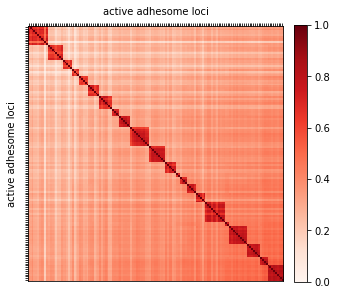

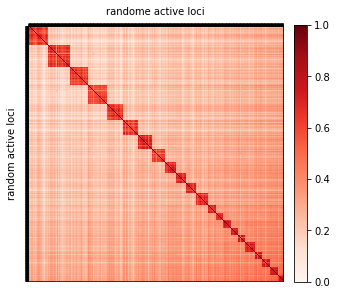

In [27]:
# Plot heatmaps
lu.plot_heatmap(avg_scaled_prox_df.loc[final_adh_loc, final_adh_loc],
                ['' for _ in final_adh_loc], ['' for _ in final_adh_loc], 
                'active adhesome loci', 'active adhesome loci', 
                size=5, fontsize=5,
                vmax=avg_scaled_prox_df.max().max(), 
                save_to=saving_main_dir+f'fig_6a.pdf',
                add_patches = [],
                cmap='Reds')
lu.plot_heatmap(avg_scaled_prox_df.loc[final_rand_loc, final_rand_loc],
                ['' for _ in final_rand_loc], ['' for _ in final_rand_loc], 
                'randome active loci', 'random active loci', 
                size=5, fontsize=5,
                vmax=avg_scaled_prox_df.max().max(), 
                save_to=saving_main_dir+f'fig_6b.pdf',
                add_patches = [],
                cmap='Reds')

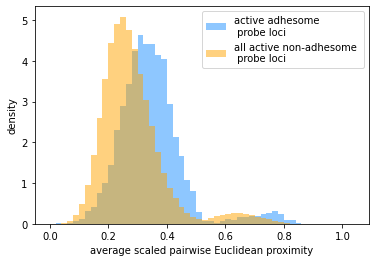

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=67.98310996633053, pvalue=0.0)


In [31]:
# Plot histogram of MERFISH distances
plt.figure()
plt.hist(avg_scaled_prox_df.loc[final_adh_loc,final_adh_loc].values[np.triu_indices(len(final_adh_loc),1)], 
         color='dodgerblue', alpha=0.5, density=True, bins=np.arange(0, 1.05, 0.02),
         label='active adhesome \n probe loci')
plt.hist(avg_scaled_prox_df.loc[final_rand_loc,final_rand_loc].values[np.triu_indices(len(final_rand_loc),1)], 
         color='orange', alpha=0.5, density=True, bins=np.arange(0, 1.05, 0.02),
         label='all active non-adhesome \n probe loci')
plt.xlabel('average scaled pairwise Euclidean proximity')
plt.ylabel('density')
plt.legend(loc='upper right')
plt.savefig(saving_main_dir+f'fig_6c.pdf', format='pdf')
plt.show()
# Wilcoxon Rank-Sums test
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(avg_scaled_prox_df.loc[final_adh_loc,final_adh_loc].values[np.triu_indices(len(final_adh_loc),1)],
                  avg_scaled_prox_df.loc[final_rand_loc,final_rand_loc].values[np.triu_indices(len(final_rand_loc),1)]))

# Validation of positive clusters

In [233]:
# Selected genes
c1 = np.array(['SHARPIN', 'HRAS', 'SLC16A3', 'CD151', 'PLEC', 'UBE2I'])
c2 = np.array(['CFL1', 'PIP5K1C', 'PKD1'])
c3 = np.array(['CAPN1', 'MAPK8IP3', 'PIAS4', 'STAT3'])
c4 = np.array(['GRB2', 'RNF185'])
c5 = np.array(['SHC1', 'TESK1', 'TLN1'])
c6 = np.array(['CRKL', 'ITGB2'])
c7 = np.array(['RAVER1', 'POLR2A'])

# Choice
negs = np.array(['GRID2', 'MED10'])
selected_genes = np.concatenate([c1, c3, negs])

In [234]:
# Create bed file for genes of interest
df_selected_pos = df_adhesome_pos[df_adhesome_pos['geneName'].isin(selected_genes)]
bed_genes = pybedtools.BedTool.from_dataframe(df_selected_pos).sort()
bed_genes_df = bed_genes.to_dataframe()

In [235]:
# Construct a bed object for MERFISH probes
df_merfish_pos = merfish_data.loc[:,'probe_locus'].to_frame().drop_duplicates()
df_merfish_pos['chrom'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[0]
df_merfish_pos['extent'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[1]
df_merfish_pos['start'] = df_merfish_pos['extent'].str.split('-', expand=True)[0].astype(int)
df_merfish_pos['end'] = df_merfish_pos['extent'].str.split('-', expand=True)[1].astype(int)
df_merfish_pos = df_merfish_pos[['chrom', 'start', 'end', 'probe_locus']]
bed_merfish = pybedtools.BedTool.from_dataframe(df_merfish_pos).sort()
bed_merfish_df = bed_merfish.to_dataframe()

In [236]:
# For each cluster, find the closest MERFISH probes to each gene
closest_probe = bed_genes.closest(bed_merfish, d=True)
closest_probe_df = closest_probe.to_dataframe()
closest_probe_df = closest_probe_df[['chrom', 'start', 'end', 'name', 'thickEnd', 'itemRgb']]
closest_probe_df.columns = ['chrom', 'start', 'end', 'gene', 'closest_probe', 'dist2probe']
selected_probes = closest_probe_df['closest_probe'].unique()
probe2name = closest_probe_df.groupby('closest_probe')['gene'].agg(list).apply(lambda x: ', '.join(x)).to_dict()

In [240]:
# Check all single cells to see if they cluster properly
cell_ids = merfish_data.groupby('cell_ID').size().sort_values(ascending=False).to_frame('size')
cell_ids = cell_ids.index.values

for cell_id in cell_ids:
    try:
        cell_data = merfish_data[merfish_data['cell_ID']==cell_id][['probe_locus', 'x(nm)', 'y(nm)', 'z(nm)']]
        cell_data = cell_data.groupby('probe_locus', as_index=False).mean()
        cell_data = cell_data.set_index('probe_locus')
        cell_dist_mat = squareform(pdist(cell_data, metric='euclidean'))
        cell_dist_df = pd.DataFrame(cell_dist_mat, columns=cell_data.index, index=cell_data.index)
        cell_scaled_dist_df = cell_dist_df/cell_dist_df.max().max()

        # Plot clustered heatmap using seaborn
        selected_dist_df = cell_scaled_dist_df.loc[selected_probes, selected_probes]
        linkage_selected = linkage(squareform(selected_dist_df.values), method='average')
        labels = np.array([probe2name[loc] for loc in selected_dist_df.index.values])
        
        # Obtain three clusters
        clusters = cut_tree(Z=linkage_selected, n_clusters=3).flatten()
        cluster_neg1 = clusters[np.where(labels==negs[0])[0][0]]
        n_members_cluster_neg1 = sum(clusters==cluster_neg1)
        cluster_neg2 = clusters[np.where(labels==negs[1])[0][0]]
        n_members_cluster_neg2 = sum(clusters==cluster_neg2)
        
        # Print cell ID if the clusters are well separated
        if (n_members_cluster_neg1==1) and (n_members_cluster_neg2==1):
            print(cell_id)
        
    except:
        pass

4295
3830
5144
4303
4591
4063
4031
4698
5132
4243
3610
3851
4950
4812
4659
3216
4411
4687
3926
4028
2210
3957
4868
3945
2949
4101
4982
3568
4540
3788
4278
5033
3711
4217
4921
4618
4174
3988
4709
4376
5039
3558
3829
5080
4904
2439
1791
2199
3077
3803
3084
2096
3553
4845
4919
4957
3129
2086
4811
2373
3338
2401
2738
3463
1824
4255
2315
1965
3850
2623
2915
1884
1932
2116
3039
3052
2153
2582
3588
4837
5193
3027
3302
2747
3425
2151
2998
2035
3589
2310
3567
2505
3684
4315


# Validation of positive clusters

Maximum genomic distance to closest probus locus = 2412680


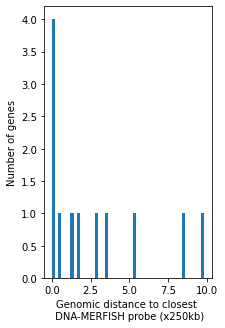

,chrom,start,end,gene,closest_probe,dist2probe,norm_dist2probe
0,chr11,532241,537321,HRAS,chr11:2950000-3050000,2412680,9.650720
1,chr11,832886,839831,CD151,chr11:2950000-3050000,2110170,8.440680
2,chr11,65180565,65212006,CAPN1,chr11:65950000-66050000,737995,2.951980
3,chr16,1308879,1327018,UBE2I,chr16:2650000-2750000,1322983,5.291932
4,chr16,1706165,1770351,MAPK8IP3,chr16:2650000-2750000,879650,3.518600
5,chr17,42313323,42388540,STAT3,chr17:42411291-42511291,22752,0.091008
6,chr17,82217933,82261129,SLC16A3,chr17:82374859-82474859,113731,0.454924
7,chr19,4007735,4039386,PIAS4,chr19:3467056-3567056,440680,1.762720
8,chr4,92303965,93810157,GRID2,chr4:92950000-93050000,0,0.000000
9,chr5,6371873,6378571,MED10,chr5:5950000-6050000,321874,1.287496


In [255]:
# Display closest_probe_df
print(f'Maximum genomic distance to closest probus locus = {closest_probe_df["dist2probe"].max()}')
hic_resol = 250000
closest_probe_df['norm_dist2probe'] = closest_probe_df['dist2probe']/hic_resol
plt.figure(figsize=(3,5))
plt.hist(closest_probe_df['norm_dist2probe'].values, bins=np.arange(0, 10, 0.2))
plt.xlabel('Genomic distance to closest \n DNA-MERFISH probe (x250kb)')
plt.ylabel('Number of genes')
plt.savefig(saving_supp_dir+f'suppfig_12b.pdf', format='pdf')
#plt.savefig(saving_supp_dir+f'suppfig_13c.pdf', format='pdf')
plt.show()      
closest_probe_df.to_csv(saving_dir+'closest_probes_control_IMR90.csv', sep='\t', header=True)
closest_probe_df

4063


<Figure size 432x288 with 0 Axes>

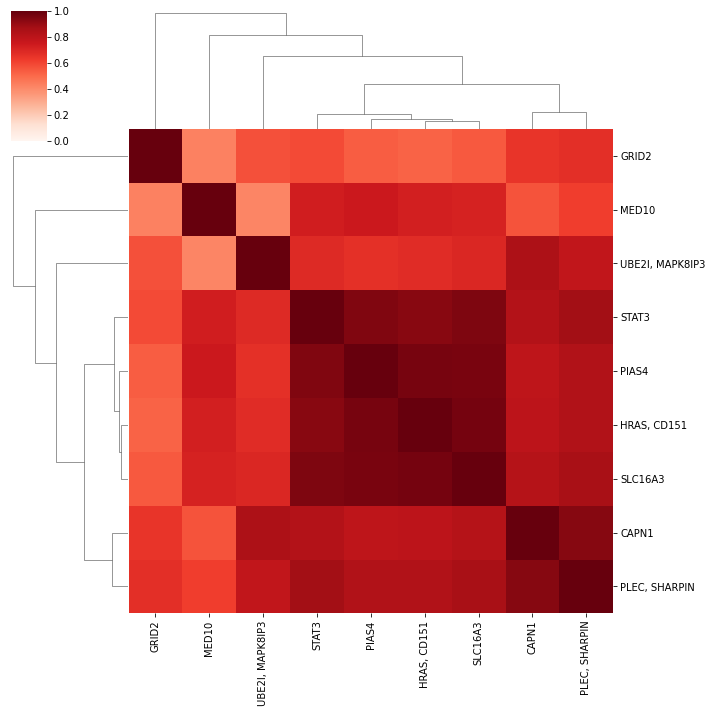

PosixPath('/home/louiscam/projects/gpcr/code/processing_FISH/graph.html')

In [256]:
# Build network

# Choice 1
cell_id = 4063
thresh = 0.8
figname = saving_supp_dir+f'suppfig_13b.pdf'

# Choice 2
# cell_id = 4784
# thresh = 0.75
# figname = saving_main_dir+f'fig_6e.pdf'


cell_data = merfish_data[merfish_data['cell_ID']==cell_id][['probe_locus', 'x(nm)', 'y(nm)', 'z(nm)']]
cell_data = cell_data.groupby('probe_locus', as_index=False).mean()
cell_data = cell_data.set_index('probe_locus')
cell_dist_mat = squareform(pdist(cell_data, metric='euclidean'))
cell_dist_df = pd.DataFrame(cell_dist_mat, columns=cell_data.index, index=cell_data.index)
cell_scaled_dist_df = cell_dist_df/cell_dist_df.max().max()

# Plot clustered heatmap using seaborn
selected_dist_df = cell_scaled_dist_df.loc[selected_probes, selected_probes]
linkage_selected = linkage(squareform(selected_dist_df.values), method='average')
labels = np.array([probe2name[loc] for loc in selected_dist_df.index.values])
print(cell_id)

selected_dist_df.index.name=''
selected_dist_df.columns.name=''
plt.figure()
sns.clustermap(1-selected_dist_df, 
               row_linkage=linkage_selected, col_linkage=linkage_selected, 
               figsize=(10, 10), row_cluster=True, col_cluster=True,
               xticklabels=labels, yticklabels=labels,
               cmap='Reds', vmin=0, vmax=1)
plt.savefig(figname, format='pdf')
plt.show()

# Threshold edges in the network and save as html
adj_df = (1-selected_dist_df.copy())*(1-selected_dist_df.copy()>thresh)
adj_df.columns = labels
adj_df.index = labels
G = nx.from_pandas_adjacency(adj_df)
nx.set_node_attributes(G, {g: gene2chrom[g.split(', ')[0]] for g in G.nodes()} , 'chromosome')
oi.output_networkx_graph_as_interactive_html(G, 'xx')